# Evaluate Random Forest on Independent Sets

## 1 Import libraries

Import libraries for data loading, model loading, TF-IDF vectoriser loading, and evaluation metrics.

In [9]:
# Core libraries
import os
import pandas as pd
import numpy as np

# For loading scikit-learn models and vectorizers
import joblib

# For loading .npz sparse matrices
from scipy.sparse import load_npz

# Scikit-learn imports for evaluation
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    classification_report
)

# For plotting confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

# For gdown to download from Google Drive
import gdown

pd.set_option('display.max_colwidth', 150)
pd.set_option('display.max_columns', 50)

print("Libraries imported.")

Libraries imported.


## 2 Load Trained Model, Vectoriser, and Define Test Set Information

Load the saved Random Forest model (`phishing_random_forest_model.joblib`) and the TF-IDF vectorizer (`tfidf_vectorizer.joblib`) from Google Drive. Define a list of the independent test set CSV files to be downloaded and evaluated.

In [10]:
# --- Define GDrive IDs and Local Filenames for Model and Vectorizer ---
RF_MODEL_GDRIVE_FILE_ID = '1S46OnX0vvYSL8UyvimiSBXm7WKg2SeEp'
RF_MODEL_LOCAL_FILENAME = 'phishing_random_forest_model.joblib'

TFIDF_VECTORIZER_GDRIVE_FILE_ID = '1JioXYHa5Roi4WxacfSJWa4LXPJPzltFA'
TFIDF_VECTORIZER_LOCAL_FILENAME = 'tfidf_vectorizer.joblib'

# --- gdown download function ---
def download_file_from_gdrive(file_id, local_filename):
    if not os.path.exists(local_filename):
        print(f"Downloading {local_filename} from Google Drive...")
        gdrive_url = f'https://drive.google.com/uc?id={file_id}'

        try:
          gdown.download(gdrive_url, local_filename, quiet=False)
          print(f"{local_filename} downloaded.")

        except Exception as e:
          print(f"ERROR downloading {local_filename}: {e}")

        return False

    else:
      print(f"{local_filename} already exists.")

    return os.path.exists(local_filename)

# --- Load Model and Vectorizer ---
rf_model = None
tfidf_vectorizer = None
model_components_loaded = True

if download_file_from_gdrive(RF_MODEL_GDRIVE_FILE_ID, RF_MODEL_LOCAL_FILENAME):
    try:
      rf_model = joblib.load(RF_MODEL_LOCAL_FILENAME)
      print(f"Loaded RF model: {RF_MODEL_LOCAL_FILENAME}")

    except Exception as e:
      print(f"Error loading RF model: {e}")
      model_components_loaded = False

else:
  model_components_loaded = False

if download_file_from_gdrive(TFIDF_VECTORIZER_GDRIVE_FILE_ID, TFIDF_VECTORIZER_LOCAL_FILENAME):
    try:
      tfidf_vectorizer = joblib.load(TFIDF_VECTORIZER_LOCAL_FILENAME)
      print(f"Loaded TF-IDF vectorizer: {TFIDF_VECTORIZER_LOCAL_FILENAME}")

    except Exception as e:
      print(f"Error loading TF-IDF vectorizer: {e}")
      model_components_loaded = False

else:
  model_components_loaded = False

if not model_components_loaded:
    print("\nERROR: Could not load the RF model or TF-IDF vectorizer. Cannot proceed with evaluation.")
else:
    print("\nRF Model and TF-IDF Vectorizer loaded successfully.")

# --- Define Independent Test Sets to Evaluate ---
# Each entry: (gdrive_id, local_filename, dataset_name, text_col_name, label_col_name)
# Ensure local_filenames match what you saved from previous notebooks.
# Ensure text_col_name correctly points to the column with cleaned text for TF-IDF.

independent_test_sets_info = [
    # SpamAssassin Easy Ham
    {
        'gdrive_id': '1Red18eXIOPbEuQfRnzt8WvgdsfYdrGH2',
        'local_filename': 'spamassassin_easy_ham_test_2500.csv',
        'dataset_name': "SpamAssassin Easy Ham",
        'text_col': 'body_cleaned',
        'label_col': 'label'
    },
    # SpamAssassin Hard Ham
    {
        'gdrive_id': '1yM_Ab-RkksL2tEe9Z88aRFh4Y_9FURoc',
        'local_filename': 'spamassassin_hard_ham_test_250.csv',
        'dataset_name': "SpamAssassin Hard Ham",
        'text_col': 'body_cleaned',
        'label_col': 'label'
    },
    # Nigerian Fraud
    {
        'gdrive_id': '1nBk5-BGtr7uNSctwNowmy8QWwv9XEt7-',
        'local_filename': 'nigerian_fraud_test_processed_3978.csv',
        'dataset_name': "Nigerian Fraud Test",
        'text_col': 'body_cleaned_minimal',
        'label_col': 'label'
    },
    # Nazario Spam
    {
        'gdrive_id': '1RDIiMFLfz9YOvw1M6lYmOzmJSILJaQ7d',
        'local_filename': 'nazario_phishing_test_processed_1561.csv',
        'dataset_name': "Nazario Phishing Test",
        'text_col': 'body_cleaned',
        'label_col': 'label'
    },
    # Additional SpamAssassin
    {
        'gdrive_id': '16jkyCOQ1IBdcZjoJv8XeUz6IAM7UmrRM',
        'local_filename': 'spamassassin_phishing_for_training_1896.csv',
        'dataset_name': "SpamAssassin Spam/Phish (Separate Training Data)",
        'text_col': 'body_cleaned',
        'label_col': 'label'
    }
]

print(f"\nDefined {len(independent_test_sets_info)} independent test sets for evaluation.")

phishing_random_forest_model.joblib already exists.
Loaded RF model: phishing_random_forest_model.joblib
tfidf_vectorizer.joblib already exists.
Loaded TF-IDF vectorizer: tfidf_vectorizer.joblib

RF Model and TF-IDF Vectorizer loaded successfully.

Defined 5 independent test sets for evaluation.


## 3 Define evaluation helper function

A function to take a dataframe, text column, label column, apply TF-IDF transform, predict with the RF model, and print metrics.

In [11]:
print("Defining evaluation helper function...")

def evaluate_rf_on_test_set(df, text_column_name, label_column_name, dataset_name_str, vectorizer, model):
    print(f"\n--- Evaluating Random Forest on: {dataset_name_str} ---")

    if df.empty or text_column_name not in df.columns or label_column_name not in df.columns:
        print(f"DataFrame for {dataset_name_str} is empty or missing required columns. Skipping.")
        return None

    # Prepare text data and labels
    texts_to_transform = df[text_column_name].fillna('') # Ensure no NaNs
    y_true_external = df[label_column_name].astype(int)

    print(f"Transforming text data for {dataset_name_str} using loaded TF-IDF vectorizer...")

    try:
        X_external_tfidf = vectorizer.transform(texts_to_transform)

    except Exception as e:
        print(f"Error during TF-IDF transformation for {dataset_name_str}: {e}")
        return None

    print(f"Making predictions with loaded Random Forest model...")

    try:
        y_pred_external = model.predict(X_external_tfidf)

        # Probabilities for positive class
        y_proba_external = model.predict_proba(X_external_tfidf)[:, 1]

    except Exception as e:
        print(f"Error during prediction for {dataset_name_str}: {e}")
        return None

    # Calculate metrics
    acc = accuracy_score(y_true_external, y_pred_external)
    prec = precision_score(y_true_external, y_pred_external, zero_division=0)
    rec = recall_score(y_true_external, y_pred_external, zero_division=0)
    f1 = f1_score(y_true_external, y_pred_external, zero_division=0)

    try:
        roc_auc = roc_auc_score(y_true_external, y_proba_external)

    except ValueError:
        roc_auc = float('nan')
        print("Warning: ROC AUC for RF could not be computed (possibly only one class in y_true or y_proba).")

    print(f"\nResults for {dataset_name_str}:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision (Phishing): {prec:.4f}")
    print(f"  Recall (Phishing):    {rec:.4f}")
    print(f"  F1-score (Phishing):  {f1:.4f}")
    print(f"  ROC AUC:   {roc_auc:.4f}")
    print("\n  Classification Report:")
    print(classification_report(y_true_external, y_pred_external, zero_division=0))

    cm = confusion_matrix(y_true_external, y_pred_external, labels=model.classes_) # Ensure labels are in correct order
    plt.figure(figsize=(5,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=[f'Pred {model.classes_[0]} (Ham)', f'Pred {model.classes_[1]} (Phish)'],
                yticklabels=[f'True {model.classes_[0]} (Ham)', f'True {model.classes_[1]} (Phish)'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {dataset_name_str}')
    plt.show()

    return {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1, 'ROC_AUC': roc_auc}

print("Evaluation helper function defined.")

Defining evaluation helper function...
Evaluation helper function defined.


## 4 Evaluate RF Model on Each Independent Test Set

Loop through the defined test sets, load each one, apply TF-IDF transform using the *already fitted* vectorizer,
make predictions with the loaded Random Forest model, and print the evaluation metrics.


--- Processing Test Set: SpamAssassin Easy Ham ---
spamassassin_easy_ham_test_2500.csv already exists.

--- Evaluating Random Forest on: SpamAssassin Easy Ham ---
Transforming text data for SpamAssassin Easy Ham using loaded TF-IDF vectorizer...
Making predictions with loaded Random Forest model...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



Results for SpamAssassin Easy Ham:
  Accuracy:  0.9328
  Precision (Phishing): 0.0000
  Recall (Phishing):    0.0000
  F1-score (Phishing):  0.0000
  ROC AUC:   nan

  Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.97      2500
           1       0.00      0.00      0.00         0

    accuracy                           0.93      2500
   macro avg       0.50      0.47      0.48      2500
weighted avg       1.00      0.93      0.97      2500



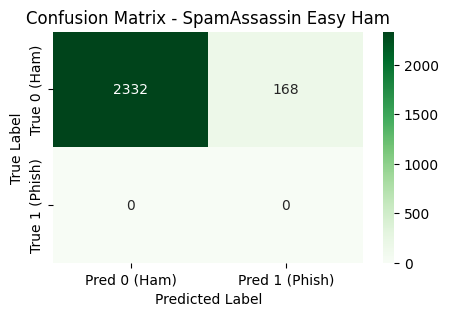


--- Processing Test Set: SpamAssassin Hard Ham ---
spamassassin_hard_ham_test_250.csv already exists.

--- Evaluating Random Forest on: SpamAssassin Hard Ham ---
Transforming text data for SpamAssassin Hard Ham using loaded TF-IDF vectorizer...
Making predictions with loaded Random Forest model...

Results for SpamAssassin Hard Ham:
  Accuracy:  0.9800
  Precision (Phishing): 0.0000
  Recall (Phishing):    0.0000
  F1-score (Phishing):  0.0000
  ROC AUC:   nan

  Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       250
           1       0.00      0.00      0.00         0

    accuracy                           0.98       250
   macro avg       0.50      0.49      0.49       250
weighted avg       1.00      0.98      0.99       250



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


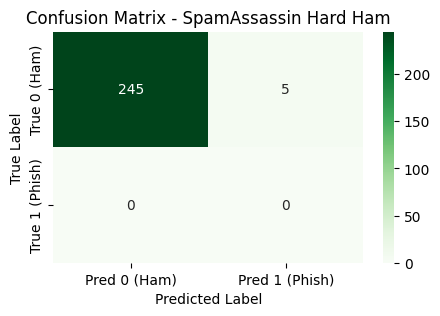


--- Processing Test Set: Nigerian Fraud Test ---
nigerian_fraud_test_processed_3978.csv already exists.

--- Evaluating Random Forest on: Nigerian Fraud Test ---
Transforming text data for Nigerian Fraud Test using loaded TF-IDF vectorizer...
Making predictions with loaded Random Forest model...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



Results for Nigerian Fraud Test:
  Accuracy:  0.0261
  Precision (Phishing): 1.0000
  Recall (Phishing):    0.0261
  F1-score (Phishing):  0.0510
  ROC AUC:   nan

  Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.03      0.05      3978

    accuracy                           0.03      3978
   macro avg       0.50      0.01      0.03      3978
weighted avg       1.00      0.03      0.05      3978



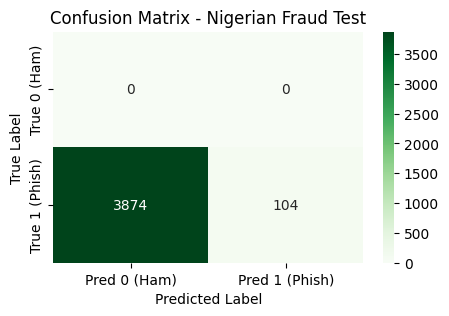


--- Processing Test Set: Nazario Phishing Test ---
nazario_phishing_test_processed_1561.csv already exists.

--- Evaluating Random Forest on: Nazario Phishing Test ---
Transforming text data for Nazario Phishing Test using loaded TF-IDF vectorizer...
Making predictions with loaded Random Forest model...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



Results for Nazario Phishing Test:
  Accuracy:  0.0730
  Precision (Phishing): 1.0000
  Recall (Phishing):    0.0730
  F1-score (Phishing):  0.1361
  ROC AUC:   nan

  Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.07      0.14      1561

    accuracy                           0.07      1561
   macro avg       0.50      0.04      0.07      1561
weighted avg       1.00      0.07      0.14      1561



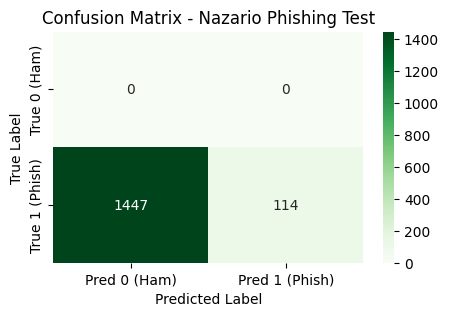


--- Processing Test Set: SpamAssassin Spam/Phish (Separate Training Data) ---
spamassassin_phishing_for_training_1896.csv already exists.

--- Evaluating Random Forest on: SpamAssassin Spam/Phish (Separate Training Data) ---
Transforming text data for SpamAssassin Spam/Phish (Separate Training Data) using loaded TF-IDF vectorizer...
Making predictions with loaded Random Forest model...

Results for SpamAssassin Spam/Phish (Separate Training Data):
  Accuracy:  0.1741
  Precision (Phishing): 1.0000
  Recall (Phishing):    0.1741
  F1-score (Phishing):  0.2965
  ROC AUC:   nan

  Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.17      0.30      1896

    accuracy                           0.17      1896
   macro avg       0.50      0.09      0.15      1896
weighted avg       1.00      0.17      0.30      1896



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


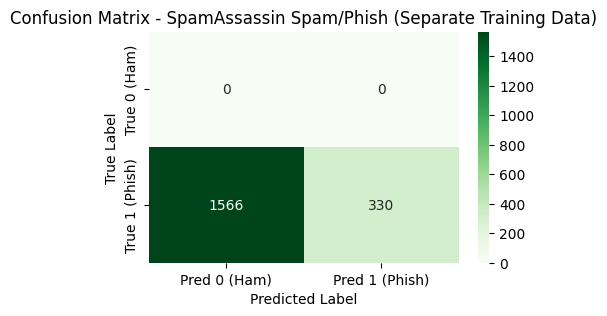



--- Summary of Random Forest Evaluations on Independent Test Sets ---

Dataset: SpamAssassin Easy Ham
  Accuracy: 0.9328
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  ROC_AUC: nan

Dataset: SpamAssassin Hard Ham
  Accuracy: 0.9800
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  ROC_AUC: nan

Dataset: Nigerian Fraud Test
  Accuracy: 0.0261
  Precision: 1.0000
  Recall: 0.0261
  F1-Score: 0.0510
  ROC_AUC: nan

Dataset: Nazario Phishing Test
  Accuracy: 0.0730
  Precision: 1.0000
  Recall: 0.0730
  F1-Score: 0.1361
  ROC_AUC: nan

Dataset: SpamAssassin Spam/Phish (Separate Training Data)
  Accuracy: 0.1741
  Precision: 1.0000
  Recall: 0.1741
  F1-Score: 0.2965
  ROC_AUC: nan


In [12]:
all_independent_results_rf = {}

if not model_components_loaded:
    print("Model or vectorizer not loaded. Cannot perform evaluations.")

else:
    for test_set_info in independent_test_sets_info:
        gdrive_id = test_set_info['gdrive_id']
        local_fname = test_set_info['local_filename']
        ds_name = test_set_info['dataset_name']
        text_c = test_set_info['text_col']
        label_c = test_set_info['label_col']

        print(f"\n--- Processing Test Set: {ds_name} ---")

        if download_file_from_gdrive(gdrive_id, local_fname):
            try:
                df_current_test_set = pd.read_csv(local_fname)

                if not df_current_test_set.empty:
                    # Ensure text column exists and handle NaNs
                    if text_c not in df_current_test_set.columns:
                        print(f"Text column '{text_c}' not found in {ds_name}. Skipping.")
                        continue

                    df_current_test_set[text_c] = df_current_test_set[text_c].fillna('')

                    # If your feature engineering combined subject and body into 'text_features_combined'
                    # you'd need to recreate that column here if it's not in the saved test CSVs.
                    # OR, ensure your saved test CSVs have the exact text column your TF-IDF vectorizer was trained on.
                    # For now, assuming 'text_c' refers to the correct column that TF-IDF expects.
                    # Example: If TF-IDF was trained on 'text_features_combined':
                    # if text_c == 'text_features_combined' and text_c not in df_current_test_set.columns:
                    #    if 'body_cleaned' in df_current_test_set.columns and 'subject_cleaned' in df_current_test_set.columns:
                    #        df_current_test_set[text_c] = df_current_test_set['subject_cleaned'].fillna('') + " " + df_current_test_set['body_cleaned'].fillna('')
                    #    elif 'body_cleaned' in df_current_test_set.columns: # Fallback to body
                    #        df_current_test_set[text_c] = df_current_test_set['body_cleaned'].fillna('')
                    #    else:
                    #        print(f"Cannot create '{text_c}' for {ds_name}. Skipping.")
                    #        continue

                    results = evaluate_rf_on_test_set(
                        df_current_test_set,
                        text_c,
                        label_c,
                        ds_name,
                        tfidf_vectorizer, # Loaded, fitted vectorizer
                        rf_model          # Loaded, trained model
                    )
                    if results:
                        all_independent_results_rf[ds_name] = results
                else:
                    print(f"DataFrame for {ds_name} is empty after loading from {local_fname}.")
            except Exception as e:
                print(f"Error processing or evaluating {ds_name} from {local_fname}: {e}")
        else:
            print(f"Could not download/access {local_fname} for {ds_name}. Skipping evaluation.")

print("\n\n--- Summary of Random Forest Evaluations on Independent Test Sets ---")

if all_independent_results_rf:
    for ds_name, metrics in all_independent_results_rf.items():
        print(f"\nDataset: {ds_name}")
        for metric_name, value in metrics.items():
            print(f"  {metric_name}: {value:.4f}")

else:
    print("No results from independent test set evaluations.")